In [15]:
# Modeling_Phase6.ipynb — Temperature only (RF & LSTM)
# Phase 6: Model Training & Evaluation

PROJECT_TITLE = "Climate Change Prediction — Pune (Phase 6: Temperature)"
SEED = 42
TARGET_COL = "temperature"
DATE_COL = "date"

LOOKBACK = 12
FORECAST_HORIZON = 1
CV_FOLDS = 5

import os
DATA_PATH = "../data/processed/pune_climate_with_co2.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"{DATA_PATH} not found.\n"
        "➡ Move pune_climate_with_co2.csv to data/processed/ or adjust the path accordingly."
    )

print("✅ DATA_PATH ->", os.path.abspath(DATA_PATH))

✅ DATA_PATH -> /Users/bishun/climate_change_prediction_pune/data/processed/pune_climate_with_co2.csv


In [16]:
# If running first time, uncomment:
# %pip install numpy pandas scikit-learn==1.5.1 seaborn==0.13.2 plotly==5.24.1 shap==0.46.0 tensorflow==2.16.2

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

import shap

import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print("TF:", tf.__version__)

TF: 2.16.2


In [17]:
# Enable MPS if available (Apple Silicon)
mps = tf.config.list_physical_devices("GPU")
print("MPS devices:", mps)

# Mixed precision for speed on M1
try:
    from tensorflow.keras import mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print("Mixed precision policy set:", policy)
except Exception as e:
    print("Mixed precision not set:", e)

MPS devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision policy set: <DTypePolicy "mixed_float16">


In [18]:
import pandas as pd
import numpy as np
import re

# --- Load (CSV only) ---
df_raw = pd.read_csv(DATA_PATH)

# 1) Normalize column names
df_raw.columns = [c.strip().lower() for c in df_raw.columns]

# 2) Flexible aliasing (handles temp_c, humidity_pct, rainfall_mm, etc.)
explicit = {
    "dt":"date","time":"date","timestamp":"date",
    "tavg":"temperature","avg_temp":"temperature","mean_temp":"temperature",
    "rh":"humidity","relative_humidity":"humidity",
    "precip":"rainfall","precipitation":"rainfall","prcp":"rainfall",
    "carbon_dioxide":"co2","co2_ppm":"co2",
    "temp_c":"temperature","humidity_pct":"humidity","rainfall_mm":"rainfall",
}
cols = df_raw.columns.tolist()
mapped = {}

def smart_guess(name):
    n = name.lower()
    if n in explicit:
        return explicit[n]
    if n == "date":
        return "date"
    if n == "co2" or "co2" in n:
        return "co2"
    # heuristics
    if re.search(r"\btemp\b|temperature|^t_", n):
        return "temperature"
    if "humid" in n or n.endswith("_pct") or n.endswith("_percent"):
        return "humidity"
    if "rain" in n or "precip" in n or n.endswith("_mm"):
        return "rainfall"
    return name  # leave others as-is

for c in cols:
    tgt = smart_guess(c)
    # avoid accidental collisions: if two map to same target, keep the first
    if tgt in mapped.values() and tgt in {"temperature","humidity","rainfall","date","co2"}:
        # keep original name for duplicates
        mapped[c] = c
    else:
        mapped[c] = tgt

df_raw = df_raw.rename(columns=mapped)

# 3) Hard requirements (after mapping)
required = {"date","temperature"}
missing = [c for c in required if c not in df_raw.columns]
if missing:
    raise KeyError(
        f"Required columns missing after mapping: {missing}\n"
        f"Original columns: {cols}\nMapped columns: {list(df_raw.columns)}"
    )

# 4) Parse dates, sort, de-dup
df = df_raw.copy()
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = (df.dropna(subset=["date"])
        .sort_values("date")
        .drop_duplicates(subset=["date"])
        .reset_index(drop=True))

# 5) Detect cadence → resample to monthly only if daily-like
is_daily_like = False
if len(df) > 5:
    dgap = df["date"].diff().dt.days.dropna()
    is_daily_like = (not dgap.empty) and (dgap.median() <= 3)

if is_daily_like:
    agg_map = {}
    if "temperature" in df.columns: agg_map["temperature"] = "mean"
    if "humidity"    in df.columns: agg_map["humidity"]    = "mean"
    if "rainfall"    in df.columns: agg_map["rainfall"]    = "sum"
    if "co2"         in df.columns: agg_map["co2"]         = "mean"
    for c in df.select_dtypes(include=[np.number]).columns:
        if c not in agg_map:
            agg_map[c] = "mean"

    df = (df.set_index("date")
            .resample("MS")
            .agg(agg_map)
            .reset_index())
else:
    # align to month start without aggregating if already monthly-ish
    df["date"] = df["date"].dt.to_period("M").dt.to_timestamp("MS")
    group_map = {}
    if "temperature" in df.columns: group_map["temperature"] = "mean"
    if "humidity"    in df.columns: group_map["humidity"]    = "mean"
    if "rainfall"    in df.columns: group_map["rainfall"]    = "sum"
    if "co2"         in df.columns: group_map["co2"]         = "mean"
    df = df.groupby("date", as_index=False).agg(group_map)

# 6) Enforce continuous monthly index (keeps NaNs for missing months)
full_months = pd.date_range(df["date"].min(), df["date"].max(), freq="MS")
df = df.set_index("date").reindex(full_months).rename_axis("date").reset_index()

# 7) Downcast numerics
for c in df.select_dtypes(include=[np.number]).columns:
    df[c] = pd.to_numeric(df[c], errors="coerce").astype("float32")

# 8) Quick sanity
print("✅ Data loaded and normalized")
print(df.head(3))
print(df.tail(3))
print("Shape:", df.shape)
print("Columns:", list(df.columns))
print("Missing (any):", {k:int(v) for k,v in df.isna().sum().items()})

✅ Data loaded and normalized
        date  temperature  humidity  rainfall  co2  solar_mj
0 1951-01-01          NaN       NaN  0.478959  NaN       NaN
1 1951-02-01          NaN       NaN  0.000000  NaN       NaN
2 1951-03-01          NaN       NaN  0.000000  NaN       NaN
          date  temperature   humidity   rainfall         co2   solar_mj
885 2024-10-01    23.871290  85.861610  54.016285  422.380005  17.139677
886 2024-11-01    19.811001  77.268669   0.000000  423.850006  16.416666
887 2024-12-01    20.016775  74.492256   6.223917  425.399994  15.373871
Shape: (888, 6)
Columns: ['date', 'temperature', 'humidity', 'rainfall', 'co2', 'solar_mj']
Missing (any): {'date': 0, 'temperature': 360, 'humidity': 360, 'rainfall': 0, 'co2': 86, 'solar_mj': 396}


In [19]:
# Create safe feature set: lag(1,3,12) and rolling mean(3,12) for key drivers
work = df.copy()

def add_lags_rolls(frame, base_cols, lags=(1,3,12), rolls=(3,12)):
    f = frame.copy()
    for col in base_cols:
        for L in lags:
            f[f"{col}_lag{L}"] = f[col].shift(L)
        for W in rolls:
            f[f"{col}_roll{W}"] = f[col].rolling(W, min_periods=1).mean()
    return f

base_cols = ["temperature","rainfall","humidity"]
# include external drivers if present
if "co2" in work.columns:
    base_cols.append("co2")

feat = add_lags_rolls(work, base_cols)

# Drop initial rows with NaN due to lags
feat = feat.dropna().reset_index(drop=True)

feat.head(3), feat.shape

(        date  temperature   humidity  rainfall         co2   solar_mj  \
 0 1984-01-01    19.133549  53.152905   0.00000  344.209991  17.789032   
 1 1984-02-01    21.581724  46.357586  33.89468  344.920013  19.963448   
 2 1984-03-01    26.988386  32.670647   0.00000  345.679993  23.425806   
 
    temperature_lag1  temperature_lag3  temperature_lag12  temperature_roll3  \
 0         19.552580         21.650644          19.338709          19.218487   
 1         19.133549         18.969334          19.526428          20.089284   
 2         21.581724         19.552580          23.983549          22.567886   
 
    ...  humidity_lag1  humidity_lag3  humidity_lag12  humidity_roll3  \
 0  ...      67.819351      85.344513       50.767742       64.301863   
 1  ...      53.152905      71.933334       49.241428       55.776614   
 2  ...      46.357586      67.819351       44.738064       44.060379   
 
    humidity_roll12    co2_lag1    co2_lag3   co2_lag12   co2_roll3  co2_roll12  
 0  

In [20]:
N = len(feat)
train_end = int(0.70 * N)
val_end   = int(0.85 * N)

train = feat.iloc[:train_end].copy()
val   = feat.iloc[train_end:val_end].copy()
test  = feat.iloc[val_end:].copy()

feature_cols = [c for c in feat.columns if c not in [DATE_COL, TARGET_COL]]

X_train, y_train = train[feature_cols], train[TARGET_COL]
X_val,   y_val   = val[feature_cols],   val[TARGET_COL]
X_test,  y_test  = test[feature_cols],  test[TARGET_COL]

print("Splits:", len(train), len(val), len(test))

Splits: 344 74 74


In [21]:
def metrics(y_true, y_pred, prefix=""):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))).mean() * 100.0
    return {
        f"{prefix}MAE": mae, f"{prefix}RMSE": rmse,
        f"{prefix}R2": r2,   f"{prefix}MAPE": mape
    }

def plotly_actual_vs_pred(df_time, y_true, y_pred, title, date_index):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=date_index, y=y_true, mode='lines', name='Actual'))
    fig.add_trace(go.Scatter(x=date_index, y=y_pred, mode='lines', name='Predicted'))
    fig.update_layout(title=title, xaxis_title="Date", yaxis_title="Temperature (°C)", hovermode="x unified")
    fig.show()

def seaborn_residuals(y_true, y_pred, title="Residuals"):
    residuals = y_true - y_pred
    fig, ax = plt.subplots(figsize=(6,4))
    sns.kdeplot(residuals, fill=True, ax=ax)
    ax.axvline(0, ls="--", lw=1, color="black")
    ax.set_title(title)
    ax.set_xlabel("Residual (°C)")
    plt.tight_layout()
    plt.show()

In [22]:
# ---- Metrics helper (version-safe + baseline support) ----
def metrics(y_true, y_pred, prefix=""):
    y_true = np.asarray(y_true, dtype=float).ravel()
    y_pred = np.asarray(y_pred, dtype=float).ravel()

    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)   # version-safe
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mape = (np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-6, None))).mean() * 100.0
    return {f"{prefix}MAE": mae, f"{prefix}RMSE": rmse, f"{prefix}R2": r2, f"{prefix}MAPE": mape}

# ---- Naïve baseline (persistence: predict previous month's temperature) ----
naive_pred = y_test.shift(1).fillna(method="bfill")   # 1-step lag baseline
naive_rmse = np.sqrt(mean_squared_error(y_test, naive_pred))
print(f"Naïve baseline RMSE: {naive_rmse:.3f}")

def skill_score_rmse(rmse_model, rmse_naive):
    """Skill score: 1 − (model_RMSE / naive_RMSE)"""
    return 1.0 - (rmse_model / rmse_naive)

# ---- Random Forest Walk-Forward CV ----
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([y_train, y_val], axis=0)

tscv = TimeSeriesSplit(n_splits=CV_FOLDS)
cv_rows, best_params, best_rmse = [], None, float("inf")

param_grid = {
    "n_estimators": [300, 600],
    "max_depth": [None, 12, 18],
    "min_samples_leaf": [1, 2],
    "max_features": ["sqrt"]
}

for n in param_grid["n_estimators"]:
    for d in param_grid["max_depth"]:
        for msl in param_grid["min_samples_leaf"]:
            for mf in param_grid["max_features"]:
                fold_metrics = []
                for fold, (train_idx, val_idx) in enumerate(tscv.split(X_trval)):
                    X_tr_, X_val_ = X_trval.iloc[train_idx], X_trval.iloc[val_idx]
                    y_tr_, y_val_ = y_trval.iloc[train_idx], y_trval.iloc[val_idx]

                    rf = RandomForestRegressor(
                        n_estimators=n, max_depth=d, min_samples_leaf=msl,
                        max_features=mf, random_state=SEED, n_jobs=-1
                    )
                    rf.fit(X_tr_, y_tr_)
                    pred = rf.predict(X_val_)
                    ms = metrics(y_val_, pred, prefix="")
                    ms.update({
                        "fold": fold,
                        "n_estimators": n,
                        "max_depth": d,
                        "min_samples_leaf": msl,
                        "max_features": mf
                    })
                    fold_metrics.append(ms)

                rmse_mean = np.mean([m["RMSE"] for m in fold_metrics])
                if rmse_mean < best_rmse:
                    best_rmse, best_params = rmse_mean, (n, d, msl, mf)
                cv_rows.extend(fold_metrics)
                print(f"Grid ({n},{d},{msl},{mf}) → CV RMSE ≈ {rmse_mean:.3f}")

cv_df = pd.DataFrame(cv_rows)
display(cv_df.groupby(["n_estimators","max_depth","min_samples_leaf","max_features"])
        [["MAE","RMSE","R2","MAPE"]].mean().sort_values("RMSE").head(10))

print(f"\n✅ Best RF params = {best_params}, CV RMSE = {best_rmse:.3f}")

# ---- Train final RF on TRAIN+VAL with best params ----
n, d, msl, mf = best_params
rf_final = RandomForestRegressor(
    n_estimators=n, max_depth=d, min_samples_leaf=msl,
    max_features=mf, random_state=SEED, n_jobs=-1
)
rf_final.fit(X_trval, y_trval)

# ---- Evaluate ----
rf_test_pred = rf_final.predict(X_test)
rf_val_pred  = rf_final.predict(X_val)

rf_test_metrics = metrics(y_test, rf_test_pred, prefix="RF Test ")
rf_val_metrics  = metrics(y_val,  rf_val_pred,  prefix="RF Val ")

# ---- Add skill score vs naïve ----
rf_test_metrics["RF Test Skill Score"] = skill_score_rmse(rf_test_metrics["RF Test RMSE"], naive_rmse)
rf_val_metrics["RF Val Skill Score"]  = skill_score_rmse(rf_val_metrics["RF Val RMSE"],  naive_rmse)

print("\nRF Validation metrics:\n", rf_val_metrics)
print("\nRF Test metrics:\n", rf_test_metrics)

Naïve baseline RMSE: 2.261
Grid (300,None,1,sqrt) → CV RMSE ≈ 0.777
Grid (300,None,2,sqrt) → CV RMSE ≈ 0.777
Grid (300,12,1,sqrt) → CV RMSE ≈ 0.775
Grid (300,12,2,sqrt) → CV RMSE ≈ 0.778
Grid (300,18,1,sqrt) → CV RMSE ≈ 0.777
Grid (300,18,2,sqrt) → CV RMSE ≈ 0.777
Grid (600,None,1,sqrt) → CV RMSE ≈ 0.768
Grid (600,None,2,sqrt) → CV RMSE ≈ 0.775
Grid (600,12,1,sqrt) → CV RMSE ≈ 0.766
Grid (600,12,2,sqrt) → CV RMSE ≈ 0.776
Grid (600,18,1,sqrt) → CV RMSE ≈ 0.769
Grid (600,18,2,sqrt) → CV RMSE ≈ 0.775


MAE      RMSE  \
n_estimators max_depth min_samples_leaf max_features                       
600          12.0      1                sqrt          0.586568  0.766133   
             18.0      1                sqrt          0.588837  0.768674   
300          12.0      1                sqrt          0.592248  0.774779   
600          18.0      2                sqrt          0.595522  0.775023   
             12.0      2                sqrt          0.596176  0.775664   
300          18.0      1                sqrt          0.594459  0.776570   
                       2                sqrt          0.596412  0.777230   
             12.0      2                sqrt          0.596880  0.778040   

                                                            R2      MAPE  
n_estimators max_depth min_samples_leaf max_features                      
600          12.0      1                sqrt          0.932497  2.558172  
             18.0      1                sqrt          0.932062  2.569937  
300          12.0      1                sqrt          0.930832  2.577925  
600          18.0      2                sqrt          0.930701  2.593434  
             12.0      2                sqrt          0.930609  2.597587  
300          18.0      1                sqrt          0.930579  2.590493  
                       2                sqrt          0.930172  2.593482  
             12.0      2                sqrt          0.930055  2.596735


✅ Best RF params = (600, 12, 1, 'sqrt'), CV RMSE = 0.766

RF Validation metrics:
 {'RF Val MAE': 0.16603390368033644, 'RF Val RMSE': 0.21054209222881715, 'RF Val R2': 0.9952235865242104, 'RF Val MAPE': 0.7188326678951971, 'RF Val Skill Score': 0.9068906737037546}

RF Test metrics:
 {'RF Test MAE': 0.6049953164898622, 'RF Test RMSE': 0.874395427343344, 'RF Test R2': 0.9198975746274892, 'RF Test MAPE': 2.5699479692742417, 'RF Test Skill Score': 0.613310724261374}


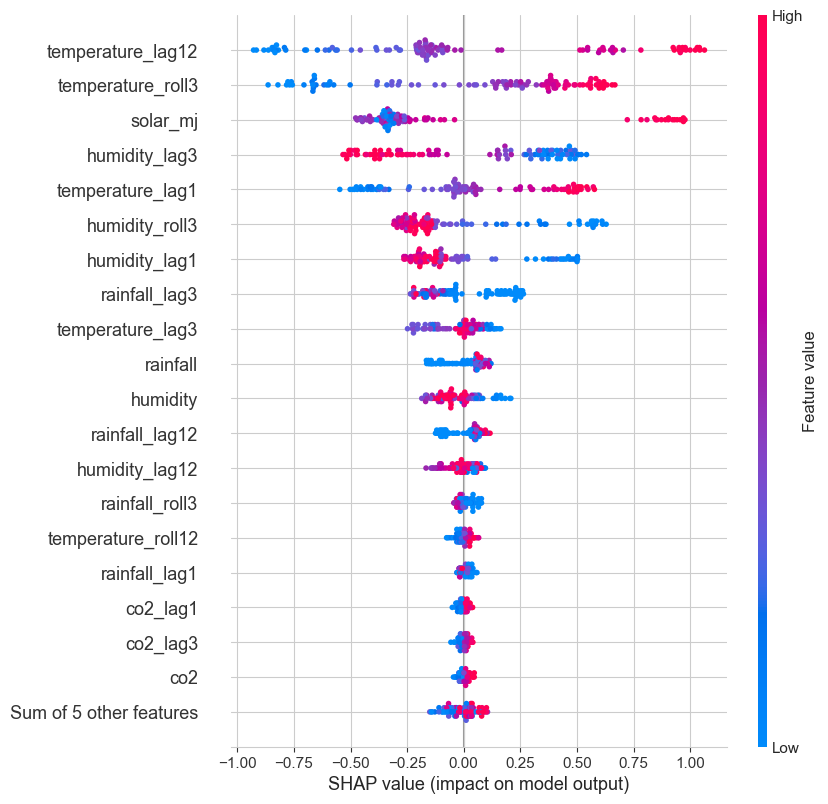

In [23]:
# Permutation Importance (on validation slice)
perm = permutation_importance(rf_final, X_val, y_val, n_repeats=10, random_state=SEED, n_jobs=-1)
perm_df = pd.DataFrame({"feature": X_val.columns, "importance": perm.importances_mean}) \
            .sort_values("importance", ascending=False)

fig = px.bar(perm_df.head(20), x="importance", y="feature", orientation="h",
             title="RF — Permutation Importance (Validation)")
fig.update_layout(yaxis={'categoryorder':'total ascending'})
fig.show()

# SHAP (TreeExplainer)
explainer = shap.TreeExplainer(rf_final)
# Use a small background sample for speed
bg = shap.sample(X_trval, 100, random_state=SEED)
shap_values = explainer(bg)

shap.plots.beeswarm(shap_values, max_display=20)  # static matplotlib output

In [24]:
# Build supervised sequences for LSTM from the same 'feat' dataframe using feature_cols
all_X = feat[feature_cols].values.astype(np.float32)
all_y = feat[TARGET_COL].values.astype(np.float32)
all_dates = feat[DATE_COL].values

def make_sequences(X, y, dates, lookback=12, horizon=1):
    Xs, ys, ds = [], [], []
    for i in range(lookback, len(X) - horizon + 1):
        Xs.append(X[i - lookback:i, :])
        ys.append(y[i + horizon - 1])
        ds.append(dates[i + horizon - 1])
    return np.array(Xs), np.array(ys), np.array(ds)

X_seq, y_seq, d_seq = make_sequences(all_X, all_y, all_dates, LOOKBACK, FORECAST_HORIZON)

# Re-map split indices to sequence indices
# We dropped early rows for lags earlier; now sequences drop another LOOKBACK
seq_offset = len(all_X) - len(X_seq)
train_end_seq = max(0, train_end - seq_offset)
val_end_seq   = max(0, val_end   - seq_offset)

Xtr_seq, ytr_seq = X_seq[:train_end_seq], y_seq[:train_end_seq]
Xv_seq,  yv_seq  = X_seq[train_end_seq:val_end_seq], y_seq[train_end_seq:val_end_seq]
Xte_seq, yte_seq = X_seq[val_end_seq:], y_seq[val_end_seq:]
dtr_seq, dv_seq, dte_seq = d_seq[:train_end_seq], d_seq[train_end_seq:val_end_seq], d_seq[val_end_seq:]

Xtr_seq.shape, Xv_seq.shape, Xte_seq.shape

((332, 12, 24), (74, 12, 24), (74, 12, 24))

In [25]:
tf.keras.backend.clear_session()

def build_lstm(input_shape, units=64, dropout=0.2):
    i = keras.Input(shape=input_shape)
    x = layers.LSTM(units, return_sequences=False)(i)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(64, activation="relu")(x)
    # With mixed precision, final Dense should output float32 for stability
    out = layers.Dense(1, dtype="float32")(x)
    model = keras.Model(i, out)
    opt = keras.optimizers.Adam(learning_rate=1e-3)
    model.compile(optimizer=opt, loss="mse", metrics=[keras.metrics.MeanSquaredError(name="mse")])
    return model

lstm = build_lstm(Xtr_seq.shape[1:])
lstm.summary()

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_mse", patience=8, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_mse", factor=0.5, patience=4, min_lr=1e-5, verbose=1)
]

history = lstm.fit(
    Xtr_seq, ytr_seq,
    validation_data=(Xv_seq, yv_seq),
    epochs=100,
    batch_size=64,     # usually good for MPS; try 64–128
    verbose=1,
    callbacks=callbacks
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 12, 24)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        22,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,009 (105.50 KB)

 Trainable params: 27,009 (105.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 487.6728 - mse: 487.6728 - val_loss: 434.6374 - val_mse: 434.6374 - learning_rate: 0.0010
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 412.3558 - mse: 412.3558 - val_loss: 360.3111 - val_mse: 360.3111 - learning_rate: 0.0010
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 339.3231 - mse: 339.3231 - val_loss: 289.3253 - val_mse: 289.3253 - learning_rate: 0.0010
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 272.0355 - mse: 272.0355 - val_loss: 224.1122 - val_mse: 224.1122 - learning_rate: 0.0010
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 209.9176 - mse: 209.9176 - val_loss: 170.3596 - val_mse: 170.3596 - learning_rate: 0.0010
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 156.1929 - mse: 156.1929 - val_loss: 120.0339 - val_mse: 120.0339 - learning_rate: 0.0010
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 112.8023 - mse: 112.8023 - val_loss: 82.7879 - val_mse

In [26]:
# Predictions
lstm_val_pred = lstm.predict(Xv_seq).ravel()
lstm_test_pred = lstm.predict(Xte_seq).ravel()

lstm_val_metrics  = metrics(yv_seq, lstm_val_pred, prefix="LSTM Val ")
lstm_test_metrics = metrics(yte_seq, lstm_test_pred, prefix="LSTM Test ")
lstm_val_metrics, lstm_test_metrics

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


({'LSTM Val MAE': 1.5217976183504671,
  'LSTM Val RMSE': 1.9631041331299022,
  'LSTM Val R2': 0.5847489673878372,
  'LSTM Val MAPE': 6.294309349689846},
 {'LSTM Test MAE': 1.6342116433220941,
  'LSTM Test RMSE': 2.150142058072161,
  'LSTM Test R2': 0.5156445184668292,
  'LSTM Test MAPE': 6.751420836175219})

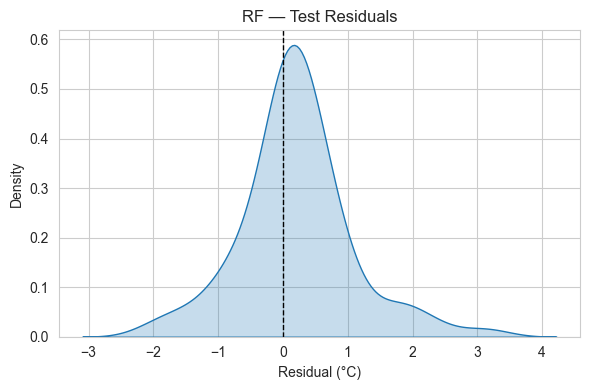

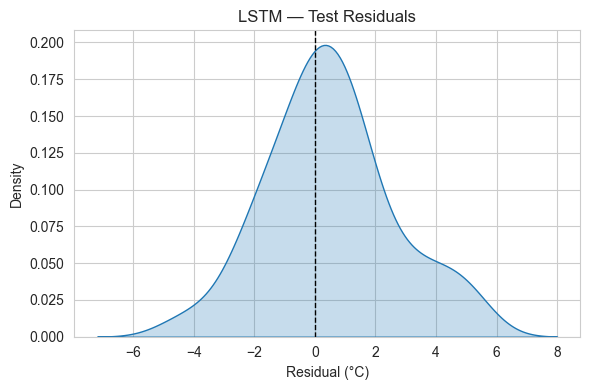

In [27]:
# RF
plotly_actual_vs_pred(val, y_val.values, rf_val_pred, "RF — Actual vs Predicted (Validation)", val[DATE_COL])
plotly_actual_vs_pred(test, y_test.values, rf_test_pred, "RF — Actual vs Predicted (Test)", test[DATE_COL])
seaborn_residuals(y_test.values, rf_test_pred, "RF — Test Residuals")

# LSTM
plotly_actual_vs_pred(pd.DataFrame({DATE_COL: dv_seq}), yv_seq, lstm_val_pred, "LSTM — Actual vs Predicted (Validation)", dv_seq)
plotly_actual_vs_pred(pd.DataFrame({DATE_COL: dte_seq}), yte_seq, lstm_test_pred, "LSTM — Actual vs Predicted (Test)", dte_seq)
seaborn_residuals(yte_seq, lstm_test_pred, "LSTM — Test Residuals")

In [28]:
leaderboard = pd.DataFrame([
    {"Model":"RandomForest", **rf_val_metrics, **rf_test_metrics},
    {"Model":"LSTM",         **lstm_val_metrics, **lstm_test_metrics}
])

# Pretty + interactive
fig = px.bar(
    leaderboard.melt(id_vars="Model", value_vars=["RF Test MAE","RF Test RMSE","LSTM Test MAE","LSTM Test RMSE"] if "RF Test MAE" in leaderboard.columns else leaderboard.columns),
    x="Model", y="value", color="variable", barmode="group",
    title="Leaderboard — Key Metrics"
)
fig.update_layout(yaxis_title="Score (lower is better)")
display(leaderboard)
fig.show()

,Model,RF Val MAE,RF Val RMSE,RF Val R2,RF Val MAPE,RF Val Skill Score,RF Test MAE,RF Test RMSE,RF Test R2,RF Test MAPE,RF Test Skill Score,LSTM Val MAE,LSTM Val RMSE,LSTM Val R2,LSTM Val MAPE,LSTM Test MAE,LSTM Test RMSE,LSTM Test R2,LSTM Test MAPE
0,RandomForest,0.166034,0.210542,0.995224,0.718833,0.906891,0.604995,0.874395,0.919898,2.569948,0.613311,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,LSTM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.521798,1.963104,0.584749,6.294309,1.634212,2.150142,0.515645,6.751421
